In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../..'))) # access sibling directories
sys.path.append(os.path.abspath(os.path.join('../../../BayesFlow_dev/BayesFlow/')))

from src.python.settings import summary_meta_validation, probability_meta_validation
from src.python.models import HierarchicalNormalSimulator
from src.python.helpers import variable_n_obs
from src.python.visualization import perf_tester, plot_metric_over_obs_repeated

import bayesflow as bf
import numpy as np
import pandas as pd
import tensorflow as tf
from functools import partial
from time import perf_counter
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt

c:\Users\lasse\projects\BayesFlow_dev\BayesFlow\bayesflow\trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Model formulation

$$
\begin{align}
x_n &\sim \mathcal{N}(\theta_l, \sigma^2) \text{ for } n=1,...,N \\
\theta_l &\sim \mathcal{N}(\mu, \tau^2) \text{ for } l=1,...,L\\
\sigma^2 &\sim Half-Normal(\sigma_s)\\
\mu &\sim \mathcal{N}(\mu_0, \tau_0)\\
\tau^2 &\sim Half-Normal(\sigma_t)\\
\end{align}
$$

$$
\begin{align}
&\text{Null Model }M_0 \text{: } \mu=0\\
&\text{Alternative Model }M_1 \text{: } \mu \text{ allowed to differ from 0} \\
\end{align}
$$

# Set up simulators

In [2]:
n_clusters = 50
n_obs_min = 1 
n_obs_max = 100

In [3]:
# Generative models
normal_model = HierarchicalNormalSimulator()

m1_simulator = partial(normal_model.generate_batch, model_index=0, n_clusters=n_clusters)
m2_simulator = partial(normal_model.generate_batch, model_index=1, n_clusters=n_clusters)
meta_model = bf.simulation.MultiGenerativeModel(
    [m1_simulator, m2_simulator], 
    shared_context_gen=partial(variable_n_obs, n_obs_min, n_obs_max)
)

# Set up networks

In [4]:
summary_net = bf.summary_networks.HierarchicalNetwork([
    bf.networks.DeepSet(dense_s1_args=summary_meta_validation['level_1']['inv_inner']['dense_inv_pre_pooling_args'],
                        dense_s2_args=summary_meta_validation['level_1']['inv_outer']['dense_inv_post_pooling_args'],
                        dense_s3_args=summary_meta_validation['level_1']['dense_equiv_args']), 
    bf.networks.DeepSet(dense_s1_args=summary_meta_validation['level_2']['inv_inner']['dense_inv_pre_pooling_args'],
                        dense_s2_args=summary_meta_validation['level_2']['inv_outer']['dense_inv_post_pooling_args'],
                        dense_s3_args=summary_meta_validation['level_2']['dense_equiv_args']) 
])
probability_net = bf.inference_networks.PMPNetwork(num_models=2, 
                                                   dense_args=probability_meta_validation['dense_args'], 
                                                   dropout=False)
amortizer = bf.amortizers.AmortizedModelComparison(probability_net, 
                                                   summary_net, 
                                                   loss_fun=partial(bf.losses.log_loss, label_smoothing=None))

In [5]:
# Training steps
epochs=20 
iterations_per_epoch=1000

# Checkpoint path for loading pretrained network and saving the final network

checkpoint_path = 'C:/Users/lasse/OneDrive/Ph.D/Projekte/hierarchical_model_comparison/checkpoints/01_calibration_validation/checkpoints_var_obs'

trainer = bf.trainers.Trainer(
    amortizer=amortizer, 
    generative_model=meta_model, 
    default_lr=0.0005,
    checkpoint_path=checkpoint_path
    )

INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


# Train & validate

In [6]:
training_time_start = perf_counter()
losses = trainer.train_online(
    epochs=epochs, iterations_per_epoch=iterations_per_epoch, batch_size=32
    )
training_time_stop = perf_counter()

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/1000 [00:00<?, ?it/s]

ECE = 0.015


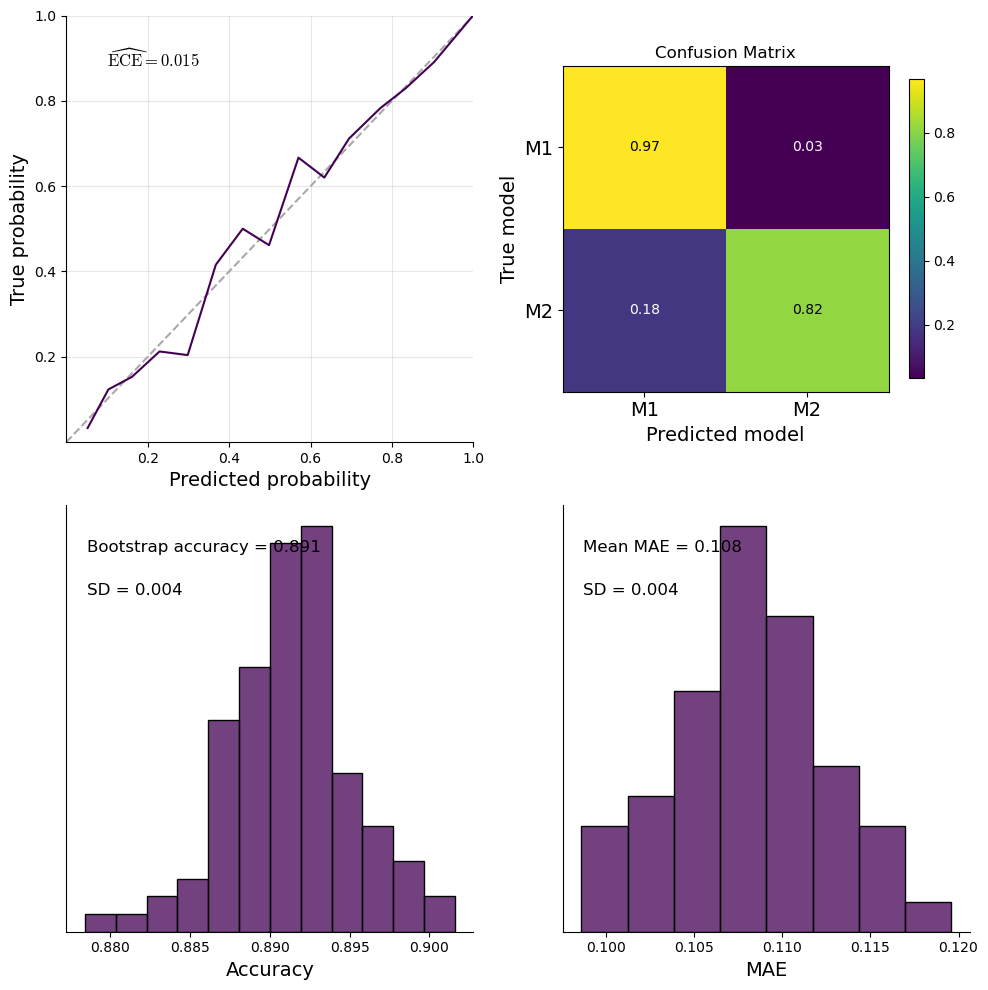

In [7]:
# Test performance with random n_obs
val_data = trainer.configurator(meta_model(5000))
perf_tester(probability_net, summary_net, val_data, variable_sizes=True, n_cal_bins=15)

In [8]:
# Get repeated predictions (takes ~55min)
n_settings = n_obs_max + 1 - n_obs_min
n_repetitions = 25
n_data_sets = 5000
n_models = 2

m_soft = np.zeros((n_settings, n_repetitions, n_data_sets, n_models))
m_true = np.zeros((n_settings, n_repetitions, n_data_sets, n_models))

for n in range(n_settings):
    for r in range(n_repetitions):
        meta_simulator = bf.simulation.MultiGenerativeModel([m1_simulator, m2_simulator], 
                                                            shared_context_gen=partial(variable_n_obs, n+1, n+2))
        data = trainer.configurator(meta_simulator(n_data_sets))

        split_direct_conditions = tf.split(data["direct_conditions"], 20)
        preds = []
        for i, x_chunk in enumerate(tf.split(data["summary_conditions"], 20)):
            embedding = summary_net(x_chunk)
            inference_net_input = np.concatenate([embedding, split_direct_conditions[i]], axis=1)
            preds.append(probability_net.posterior_probs(inference_net_input))
        m_soft[n,r,:,:] = np.concatenate(preds)
        m_true[n,r,:,:] = data["model_indices"]

        if np.mean(m_soft[n,r,:,:])==0.0:
            print(f'Warning, all preds in repetition {r} of setting {n} are zeros!')
    
    if n%25 == 0:
        print('Iteration {} finished'.format(n))

Iteration 0 finished
Iteration 25 finished
Iteration 50 finished
Iteration 75 finished


In [18]:
# Export repeated predictions
export_preds = False

if export_preds==True:
    local_timezone = datetime.now(timezone(timedelta(0))).astimezone().tzinfo

    filename_soft = pd.Timestamp.today(tz=local_timezone).strftime('%Y_%m_%d_m_soft')
    filename_true = pd.Timestamp.today(tz=local_timezone).strftime('%Y_%m_%d_m_true')
    val_folder = os.path.join(
        os.path.dirname(os.path.dirname(os.getcwd())),
        "data",
        "01_calibration_validation",
        "02_variable_observations",
    )

    np.save(os.path.join(val_folder, filename_soft), m_soft)
    np.save(os.path.join(val_folder, filename_true), m_true)

In [16]:
# Import repeated predictions
import_preds = False

if import_preds==True:
    n_settings = n_obs_max + 1 - n_obs_min
    n_repetitions = 25
    n_data_sets = 5000
    n_models = 2

    filename_soft = '2023_07_03_m_soft.npy'
    filename_true = '2023_07_03_m_true.npy'
    val_folder = os.path.join(
        os.path.dirname(os.path.dirname(os.getcwd())),
        "data",
        "01_calibration_validation",
        "02_variable_observations",
    )

    m_soft = np.load(os.path.join(val_folder, filename_soft))
    m_true = np.load(os.path.join(val_folder, filename_true))

Grand median ECE = 0.01232609742544593


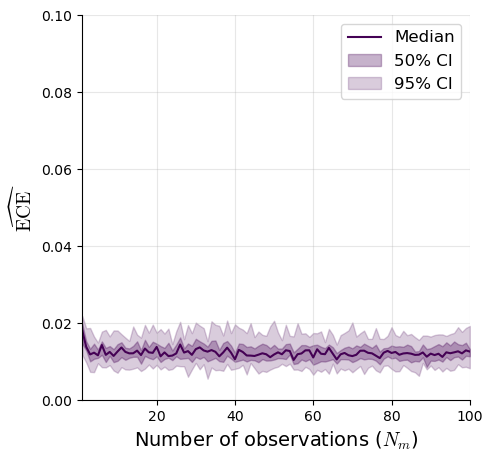

In [9]:
plot_metric_over_obs_repeated(m_true, m_soft, n_obs_min, n_obs_max, narrow_ci=[0.25, 0.75], 
                              wide_ci=[0.025, 0.975], n_repetitions=n_repetitions, metric='ECE', save=True)

Grand median Accuracy = 0.8848


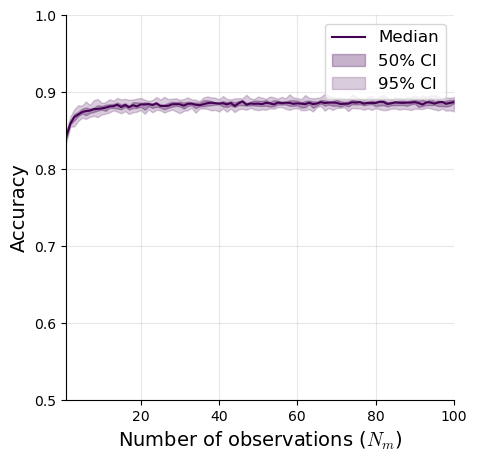

In [10]:
plot_metric_over_obs_repeated(m_true, m_soft, n_obs_min, n_obs_max, narrow_ci=[0.25, 0.75], 
                              wide_ci=[0.025, 0.975], n_repetitions=n_repetitions, metric='Accuracy', save=True)

Grand median SBC = -0.0006374131962657015


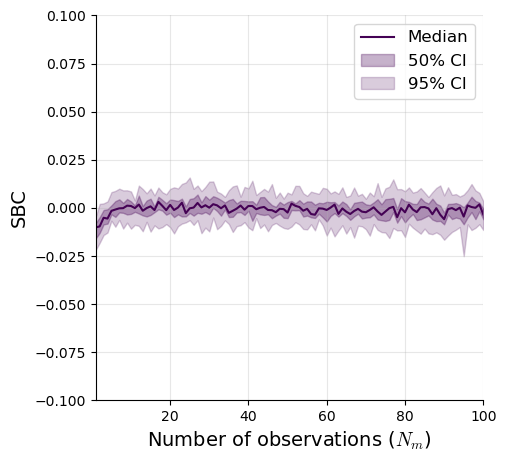

In [11]:
plot_metric_over_obs_repeated(m_true, m_soft, n_obs_min, n_obs_max, narrow_ci=[0.25, 0.75], 
                              wide_ci=[0.025, 0.975], n_repetitions=n_repetitions, metric='SBC', save=True)